### Random Forest

Dimensionality Reduction / Feature Selection

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v2.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [4]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 28, 28)
y_train Shape: (109820,)
X_test Shape: (28688, 28, 28)
y_test Shape: (28688,)


In [5]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

In [6]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [7]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

In [8]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [9]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

#### Modeling with Random Forest

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grid Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [10, 20, 30]
}

In [18]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, random_state=42, verbose=3)


In [19]:
# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train_lda, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.483 total time= 2.1min
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.486 total time= 2.1min
[CV 3/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.488 total time= 2.0min
[CV 4/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.612 total time= 2.0min
[CV 5/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.904 total time= 2.0min
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.481 total time= 2.0min
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.482 total time= 2

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=3)

In [20]:
#dumping randomized search cv into pickle file 
with open('/content/drive/Shareddrives/SignLanguageData/rfc_search.pkl','wb') as f:
  pickle.dump(rfc_search, f)

[CV 5/5] END max_depth=20, max_features=30, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=0.988 total time= 6.8min

[CV 5/5] END max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200;, score=0.995 total time= 6.2min

[CV 5/5] END max_depth=30, max_features=30, min_samples_leaf=2, min_samples_split=6, n_estimators=200;, score=0.990 total time=13.9min

[CV 5/5] END max_depth=20, max_features=30, min_samples_leaf=2, min_samples_split=6, n_estimators=300;, score=0.990 total time=20.5min

In [21]:
#display randomized search results 
pd.DataFrame(rfc_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,123.888315,2.299367,0.494918,0.038174,100,6,3,10,10,"{'n_estimators': 100, 'min_samples_split': 6, ...",0.483473,0.485658,0.488071,0.612047,0.904252,0.594700,0.162330,9
1,121.831147,1.326787,0.505046,0.041788,100,6,1,10,10,"{'n_estimators': 100, 'min_samples_split': 6, ...",0.480878,0.482289,0.490029,0.612184,0.903114,0.593699,0.162461,10
2,1324.307814,87.206788,2.667900,0.110879,300,6,2,30,20,"{'n_estimators': 300, 'min_samples_split': 6, ...",0.593881,0.600710,0.597887,0.705245,0.989847,0.697514,0.152023,6
3,871.022565,25.583416,1.738906,0.127386,200,6,2,30,30,"{'n_estimators': 200, 'min_samples_split': 6, ...",0.600437,0.608359,0.608450,0.712757,0.989756,0.703952,0.148819,4
4,832.806059,19.495190,1.619534,0.052188,200,4,3,30,30,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.597113,0.603715,0.602668,0.708022,0.989710,0.700246,0.150550,5
5,380.483070,5.798891,1.921716,0.171690,200,4,2,10,30,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.639182,0.644418,0.644236,0.737980,0.995584,0.732280,0.136748,1
6,1087.562396,34.308541,2.643457,0.119976,300,6,3,20,30,"{'n_estimators': 300, 'min_samples_split': 6, ...",0.609953,0.617419,0.615507,0.718221,0.990166,0.710253,0.145650,2
7,406.997519,8.620745,0.760688,0.020453,100,6,2,30,20,"{'n_estimators': 100, 'min_samples_split': 6, ...",0.588554,0.593608,0.593107,0.701921,0.988208,0.693080,0.153619,7
8,119.744819,1.754730,0.506458,0.049704,100,2,2,10,10,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.482198,0.488800,0.486888,0.615097,0.902978,0.595192,0.161830,8
9,1091.497278,20.007704,2.467882,0.094751,300,4,1,20,20,"{'n_estimators': 300, 'min_samples_split': 4, ...",0.608632,0.614232,0.609771,0.718949,0.991167,0.708550,0.147389,3


In [22]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 30}


The best performing model has the following parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}. 

In [ ]:
#best model
search_lda.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}

In [ ]:
#defining rfc with best parameters
rfc = 

In [ ]:
# applying RFC on Training data
y_pred_rfc = rfc.fit(X_train_lda, y_train).predict(X_train_lda)

print(f"Accuracy: {accuracy_score(y_train, y_pred_rfc)}")
print("Classification report:")
print(classification_report(y_train, y_pred_rfc, target_names=letters))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      2252
         1.0       0.83      0.90      0.86      2020
         2.0       0.97      0.95      0.96      2288
         3.0       0.83      0.83      0.83      2392
         4.0       0.87      0.87      0.87      1914
         5.0       0.89      0.88      0.89      2408
         6.0       0.92      0.89      0.91      2180
         7.0       0.92      0.89      0.90      2026
         8.0       0.80      0.86      0.83      2324
        10.0       0.86      0.85      0.86      2228
        11.0       0.87      0.89      0.88      2482
        12.0       0.87      0.82      0.85      2110
        13.0       0.86      0.85      0.85      2302
        14.0       0.95      0.95      0.95      2392
        15.0       0.96      0.95      0.95      2176
        16.0       0.96      0.96      0.96      2558
        17.0       0.75      0.80      0.78      2588
        18.0       0.84    

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rfc_test, labels=letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)
disp.plot(cmap='RdPu')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# AUC
print(f"AUC: {roc_auc}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_rfc_test)
print(f"MCC: {mcc}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_rfc_test)
print(f"Cohen's Kappa: {kappa}")

In [ ]:
# applying RFC on Test data
y_pred_rfc_test = rfc.fit(X_train_lda, y_train).predict(X_test_lda)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rfc_test)}")
print("Classification report:")
print(classification_report(y_test, y_pred_rfc_test, target_names=letters))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rfc_test, labels=letters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)
disp.plot(cmap='RdPu')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
# AUC
print(f"AUC: {roc_auc}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_rfc_test)
print(f"MCC: {mcc}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_rfc_test)
print(f"Cohen's Kappa: {kappa}")

              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57       662
         1.0       0.65      0.63      0.64       864
         2.0       0.78      0.78      0.78       620
         3.0       0.45      0.56      0.50       490
         4.0       0.65      0.54      0.59       996
         5.0       0.47      0.65      0.55       494
         6.0       0.56      0.45      0.50       696
         7.0       0.80      0.56      0.66       872
         8.0       0.38      0.40      0.39       576
        10.0       0.50      0.47      0.48       662
        11.0       0.52      0.66      0.58       418
        12.0       0.50      0.32      0.39       788
        13.0       0.32      0.28      0.30       582
        14.0       0.65      0.50      0.57       492
        15.0       0.64      0.57      0.60       694
        16.0       0.38      0.72      0.50       328
        17.0       0.08      0.19      0.11       288
        18.0       0.21    

Letter R performs significantly worse than the other letters. Inspecting R examples directly. 

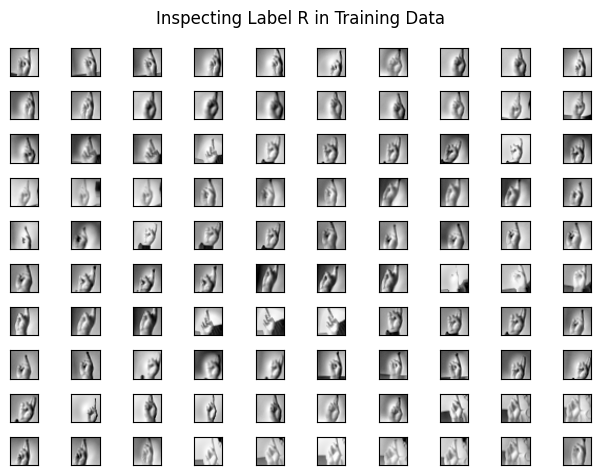

In [ ]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

#visualization of dataset 
fig, ax = plt.subplots(10,10)
plt.suptitle('Inspecting Label R in Training Data')
ax = ax.ravel()
pos = 0 

label = 17

index = find_indices(y_train,label)[0]

#loop through each label in dataset 
for i, idx in enumerate(index):
    if i >= 100:
        break
    #display first found image 
    ax[pos].imshow(X_train[idx].reshape(28,28),cmap='gray')
    #do not show ticks 
    ax[pos].set_xticks([])
    ax[pos].set_yticks([])
    #increment for subplotting 
    pos+=1

plt.tight_layout()
plt.show()